# ニューラルネットワークの基礎を理解

## ニューラルネットワークスクラッチの検証にはMNISTデータセットを使用

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

訓練用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかというラベル

## データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## 画像データの可視化

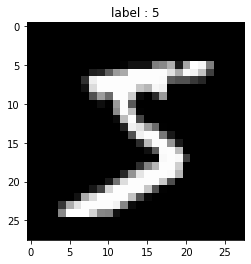

In [5]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどとまったく同じ風に表示されます。

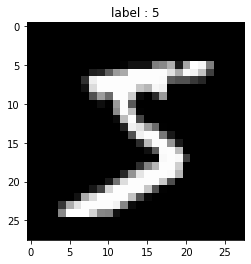

In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
#print(image) # 値を確認

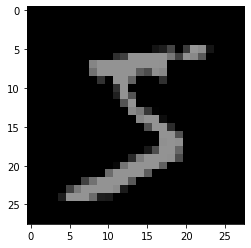

In [7]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

画像関係のライブラリではこの自動的なスケーリングが思わぬ結果を生むことがあるので、新しいメソッドを使うときには確認しておきましょう。

## 前処理

In [8]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000,)
(12000,)


In [10]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64


(48000,)
(48000, 10)
float64


さらに、訓練データ6万枚の内2割を検証データとして分割してください。訓練データが48000枚、検証データが12000枚となります。

### ミニバッチ処理

これまでの機械学習スクラッチでは、すべてのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。


今回はバッチサイズを20とします。今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練データを一度すべて見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。


これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

In [11]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        # バッチサイズ
        self.batch_size = batch_size
        # ランダムシードの固定
        np.random.seed(seed)
        # permutationは引数に配列を渡すとランダムに並び替えて返す
        shuffle_index = np.random.permutation(np.arange(X.shape[0])) #Xの行数だけ公差配列を作る
        # X,y両方を並べ替えた配列を作る
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        
        # int型に変形させる
        # astype(np.int)
        
        # 小数点以下を切り上げ、正に対して無限大に
        ce_ = np.ceil
        # 整数型になる
        self._stop = ce_(X.shape[0]/self.batch_size).astype(np.int)
        
        # 整数が帰ってくる
    def __len__(self):
        return self._stop
    
        # p0の次のバッチの開始番号がp1となる
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
        # 初期値0のカウンタ変数を返す
    def __iter__(self):
        self._counter = 0
        return self
    
        # 
    def __next__(self):
        if self._counter >= self._stop:
            # マイナスの値になった場合、エラーにする
            raise StopIteration()
        # p0,p1を更新して次の場所を返す
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### このクラスをインスタンス化し、for文を使うことでミニバッチが取り出せます。

In [32]:
# # X_train=48000,y_train=48000
# get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
# print(len(get_mini_batch)) # 2400
# print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
# print(type(get_mini_batch[5]))
# # 2400回繰り返す
# for mini_X_train, mini_y_train in get_mini_batch:
#     # このfor文内でミニバッチが使える
    
#     pass

## 学習

ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。

## 【問題1】重みの初期値を決めるコードの作成

ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。


重みの初期値はさまざまな方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。


以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

In [13]:
# n_features = 784
# n_nodes1 = 400
# n_nodes2 = 200
# n_output = 10
# sigma = 0.01 # ガウス分布の標準偏差
#self.W1 = sigma * np.random.randn(n_features, n_nodes1)
# self.W1: (784, 400)

In [14]:
# # 重みとバイアス
# self.W1 = sigma * np.random.randn(n_features,n_nodes1) #第一層の重み
# self.W2 = sigma * np.random.randn(n_nodes1,n_nodes2) #第二層の重み
# self.W3 = sigma * np.random.randn(n_nodes2,n_output) #第三層の重み
# self.B1 = sigma * np.random.randn(n_nodes1) #第一層のバイアス
# self.B2 = sigma * np.random.randn(n_nodes2) #第二層のバイアス
# self.B3 = sigma * np.random.randn(n_output) #第三層のバイアス

## 【問題2】フォワードプロパゲーションの実装

三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。


各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

「1層目」

$$
A_1=X⋅W_1+B_1
$$

$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)


$B_1$ : 1層目のバイアス (n_nodes1,)


$A_1$ : 出力 (batch_size, n_nodes1)


「1層目の活性化関数」

$$
Z_1=f(A_1)
$$

$f()$ : 活性化関数


$Z_1$ 出力 (batch_size, n_nodes1)

------------------------------------------------------

「2層目」

$$
A_2=Z_1⋅W_2+B_2
$$

$W_2$ : 2層目の重み (n_nodes1, n_nodes2)


$B_2$ : 2層目のバイアス (n_nodes2,)


$A_2$ : 出力 (batch_size, n_nodes2)


「2層目の活性化関数」

$$
Z_2=f(A_2)
$$

$f()$ : 活性化関数


$Z_2$ 出力 (batch_size, n_nodes2)

--------------------------------------------------------------

「3層目（出力層）」

$$
A_3=Z_2⋅W_3+B_3
$$

$W_3$ : 3層目の重み (n_nodes2, n_output)


$B_3$ : 3層目のバイアス (n_output,)


$A_3$ : 出力 (batch_size, n_output)


「3層目の活性化関数」

$$
Z_3=softmax(A_3)
$$

$softmax()$ : ソフトマックス関数


$Z_3$ 出力 (batch_size, n_output)


$Z_3$ は各ラベル（0〜9）に対する確率の配列である。

## 活性化関数（フォワードプロバゲーション）

活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。

---------------------------------------------------------

「シグモイド関数」

$$
f(Z)=sigmoid(A)=1/(1+exp(−A))
$$

指数関数 $exp(-A)$ の計算はnp.expを使用してください。

「ハイパボリックタンジェント関数」


次の数式で表されますが、np.tanhひとつで実現できます。

$$
f(Z)=tanh(A)=(exp(A)−exp(−A)) / (exp(A)+exp(−A))
$$ 

＊現在ではこれらの代わりにReLUと呼ばれる活性化関数が一般的です。次のSprintで扱います。

## ソフトマックス関数

ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。


次の数式です。

$$
Z_{3_k}=exp(A_{3k})/∑^{n_c}_{i=1}exp(A_{3i})
$$

$Z_{3_k}$ : $k$ 番目のクラスの確率ベクトル (batch_size,)


$A_{3_k}$ : $k$ 番目のクラスにあたる前の層からのベクトル (batch_size,)


$n_c$ : クラスの数、n_output。今回のMNISTでは10。


分母はすべてのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に $k$ 番目のクラスを持ってくることで、 $k$ 番目のクラスである確率が求まります。


これを10クラス分計算し、合わせたものが $Z_3$ です。

In [15]:
# batch_size = 20 # バッチサイズ
# n_features = 784 # 特徴量の数
# n_nodes1 = 400 # 1層目のノード数
# n_nodes2 = 200 # 2層目のノード数
# n_output = 10 # 出力のクラス数（3層目のノード数）

In [16]:

# # 活性化関数、今回はシグモイド関数
# def _sigmoid(self,X):
#     return 1 /(1 + np.exp(-X))

# # ソフトマックス関数
# def _softmax(self,X):
#     c = np.max(X)
#     exp_x = np.exp(X - c)
#     sum_exp_x = np.sum(exp_x)
#     y = exp_x / sum_exp_x
#     return y

# def forward(self,X):
#     """1層目"""
#     self.A1 = np.matmul(X,self.W1) + self.B1
#     self.Z1 = self._sigmoid(self.A1)

#     """2層目"""
#     self.A2 = np.matmul(self.Z1,self.W2) + self.B2
#     self.Z2 = self._sigmoid(self.A2)

#     """3層目"""
#     self.A3 = np.matmul(self.Z2,self.W3) + self.B3
#     self.Z3 = self._softmax(self.A3)

        



## 【問題3】交差エントロピー誤差の実装

目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 $L$ は次の数式です。

$$
L=−1/{n_b}∑^{n_b}_j∑^{n_c}_ky_{jk}log(z{3_jk})
$$

$y_{ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）


$z_{3_ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの確率（スカラー）


$n_{b}$ : バッチサイズ、batch_size


$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）

サンプル1つあたりの誤差が求まります。


実数におけるlog(x)の定義域は0 < xです。したがって、logの中身がとても小さい値になってしまったときエラーを起こします。そこでlogの中に1e-7を足すことでエラーを回避できます。


こういった処理はlogに限らず、さまざまな場所で出てくることがあります。

In [17]:
# # 交差エントロピー誤差
# def cross_entro_error(z,y,batch_size=20,n_output=10):
#     # ダブルシグマの合計値を入れるために０で初期化
#     to_sum = 0

#     # バッチの数（今回は２０）繰り返す
#     for j in range(batch_size):
#         # クラスの数（今回は１０）繰り返す
#         for k in range(n_output):
#             sum_k = y[j,k]*np.log(self.Z3[j,k])
#             to_sum += sum_k

#     L = (-1/batch_size)*to_sum
    
#     return L


## 【問題4】バックプロパゲーションの実装

三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。


数式を以下に示します。


まず、i層目の重みとバイアスの更新式です。 $W_i$ と $B_i$ に対し、更新後の $W_i^{\prime}$ と $B_i^{\prime}$ は次の数式で求められます。

$$
W′_i=W_i−α\frac{\partial L}{\partial W_i}
$$
$$
B′_i=B_i−α\frac{\partial L}{\partial B_i}
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的にはすべて同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。

この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。


勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。

「3層目」

$$
\frac{\partial L}{\partial A_3}=1/{n_b}(Z_3−Y)
$$
$$
\frac{\partial L}{\partial B_3}=∑^{n_b}_j\frac{\partial L}{\partial A_{3_j}}
$$
$$
\frac{\partial L}{\partial W_3}=Z^T_2⋅\frac{\partial L}{\partial A_3}
$$
$$
\frac{\partial L}{\partial Z_2}=\frac{\partial L}{\partial A_3}⋅W^T_3
$$

$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (batch_size, n_output)


$\frac{\partial L}{\partial A_{3_j}}$ : j番目のサンプルの$A_3$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)


$Y$ : 正解ラベル (batch_size, n_output)


$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)


$W_3$ : 3層目の重み (n_nodes2, n_output)


$n_{b}$ : バッチサイズ、batch_size

「2層目」

$$
\frac{\partial L}{\partial A_2}=\frac{\partial L}{\partial Z_2}⊙(1−tanh^2(A_2))
$$
$$
\frac{\partial L}{\partial B_2}=∑^{n_b}_j \frac{\partial L}{\partial A_{2_j}}
$$
$$
\frac{\partial L}{\partial W_2}=Z^T_1⋅\frac{\partial L}{\partial A_2}
$$
$$_
\frac{\partial L}{\partial Z_1}=\frac{\partial L}{\partial A_2}⋅W^T_2
$$

$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$\frac{\partial L}{\partial A_{2_j}}$ : j番目のサンプルの$A_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$A_2$ : 2層目の出力 (batch_size, n_nodes2)


$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)


$W_2$ : 2層目の重み (n_nodes1, n_nodes2)

「1層目」

$$
\frac{\partial L}{\partial A_1}=\frac{\partial L}{\partial Z_1}⊙(1−tanh^2(A_1))
$$
$$
\frac{\partial L}{\partial B_1}=∑^{n_b}_j \frac{\partial L}{\partial A_{1_j}}
$$
$$
\frac{\partial L}{\partial W_1}=X^T⋅\frac{\partial L}{\partial A_1}
$$

$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$\frac{\partial L}{\partial A_{1_j}}$ : j番目のサンプルの$A_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)


$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$A_1$ : 1層目の出力 (batch_size, n_nodes1)


$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)

《補足》


活性化関数にシグモイド関数を使用した場合は、次のようになります。

$$
\frac{\partial L}{\partial A_2}=\frac{\partial L}{\partial Z_2}⊙(1−sigmoid(A_2))⊙sigmoid(A_2)
$$
$$
\frac{\partial L}{\partial A_1}=\frac{\partial L}{\partial Z_1}⊙(1−sigmoid(A_1))⊙sigmoid(A_1)
$$

In [18]:
# def back_proba(self,X,y):
#     # X,yを入力すると3-1層を通過して最終出力値を返す仕組み
    
#     """3層目"""
#     # 重みに対する勾配
#     bA3 = (self.Z3 - y)/self.batch_size
#     bW3 = np.matmul(self.Z2.T,bA3)
#     # バイアスに対する勾配
#     bB3 = np.sum(bA3,axis = 0)
    
#     """2層目"""
#     # 重みに対する勾配
#     bZ2 = np.matmul(bA3,self.W3.T)
#     bA2 = bZ2 * (1 - self._sigmoid(self.A2))*self._sigmoid(self.A2)
#     bW2 = np.matmul(self.Z1.T,bA2)
#     # バイアスに対する勾配
#     bB2 = np.sum(bA2,axis = 0)
    
#     """1層目"""
#     # 重みに対する勾配
    
#     bZ1 = np.matmul(bA2,self.W2.T)
#     bA1 = bZ1 * (1 - self._sigmoid(self.A1))*self._sigmoid(self.A1)
#     bW1 = np.matmul(X.T,bA1)
#     # バイアスに対する勾配
#     bB1 = np.sum(bA1,axis = 0)
    
#     # 各勾配に学習率をかけて更新
#     self.W3 -= self.lr * bW3
#     self.B3 -= self.lr * bB3
#     self.W2 -= self.lr * bW2
#     self.B2 -= self.lr * bB2
#     self.W1 -= self.lr * bW1
#     self.B1 -= self.lr * bB1
    
    
    

## 【問題5】推定

推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

In [19]:
# def predict(self,X):
#     """予測
#     Parameters
#     ----------
#     X : 説明変数
#     """
#     # 順伝播処理
#     self.forward(X)
#     # 最も大きいインデックスをクラスとして採用
#     return np.argmax(self.Z3, axis=1)

## 【問題6】学習と推定

MNISTのデータを学習・推定し、Accuracyを計算してください。

In [35]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self,batch_size = 20,n_features = 784,n_nodes1 = 400,n_nodes2 = 200,n_output = 10,sigma = 0.02,lr = 0.01,epoch = 10, verbose = True):
        """変数の初期化
        Parameters
        ----------
        verbose : 計算過程を出力するか否か
        batch_size : ミニバッチのデータ数
        n_features : 説明変数の数
        n_nodes1 : 1層目のノードの数
        n_nodes2 : 2層目のノードの数
        n_output : 出力層のノードの数
        sigma : 重みの初期化の際のガウス分布の標準偏差
        lr : 学習率
        epoch : 学習回数
        """
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.verbose = verbose
        
        # 損失記録用
        self.loss_train = []
        self.loss_val = []
        
        # 使用する重みの初期化
        # 重みとバイアス
        self.W1 = self.sigma * np.random.randn(self.n_features,self.n_nodes1) #第一層の重み
        self.W2 = self.sigma * np.random.randn(self.n_nodes1,self.n_nodes2) #第二層の重み
        self.W3 = self.sigma * np.random.randn(self.n_nodes2,self.n_output) #第三層の重み
        self.B1 = self.sigma * np.random.randn(1,self.n_nodes1) #第一層のバイアス
        self.B2 = self.sigma * np.random.randn(1,self.n_nodes2) #第二層のバイアス
        self.B3 = self.sigma * np.random.randn(1,self.n_output) #第三層のバイアス
        pass
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 学習回数分ループ
        for _ in range(self.epoch):
            
            # ミニバッチのインスタンス化
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            
            # イテレータが停止するまで繰り返す
            for mini_X_train, mini_y_train in get_mini_batch:
                # 順伝播
                self.forward(mini_X_train)
                # 逆伝播
                self.back_proba(mini_X_train, mini_y_train)
                
            # ミニバッチ学習後のロス計算
            self.forward(X)
            self.loss_train.append(self.cross_entro_error(y, self.Z3))
            
            # 評価データがあるなら、こちらも計算
            if X_val is not None:
                self.forward(X_val)
                self.loss_val.append(self.cross_entro_error(y_val, self.Z3))
        
        
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    
    # 活性化関数、今回はシグモイド関数
    def _sigmoid(self,X):
        return 1 /(1 + np.exp(-X))
    
    def tanh_function(self, A):
        
        return np.tanh(A)

    # ソフトマックス関数
    def _softmax(self,X):
        #c = np.max(X)
        exp_x = np.exp(X)
        sum_exp_x = np.sum(exp_x,axis = 1).reshape(-1,1)
        y = (exp_x / sum_exp_x)
        return y

    def forward(self,X):
        """1層目"""
        self.A1 = X@self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)

        """2層目"""
        self.A2 = self.Z1@self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)

        """3層目"""
        self.A3 = self.Z2@self.W3 + self.B3
        self.Z3 = self._softmax(self.A3)

    def back_proba(self,X,y):
        # X,yを入力すると3-1層を通過して最終出力値を返す仕組み

        """3層目"""
        # 重みに対する勾配
        bA3 = (self.Z3 - y)/self.batch_size
        bW3 = self.Z2.T@bA3
        # バイアスに対する勾配
        bB3 = np.sum(bA3,axis = 0)

        """2層目"""
        # 重みに対する勾配
        bZ2 = bA3@self.W3.T
        #bA2 = bZ2 * (1 - self._sigmoid(self.A2))*self._sigmoid(self.A2)
        bA2 = bZ2 * (1 - self.tanh_function(self.A2)**2)
        bW2 = self.Z1.T@bA2
        # バイアスに対する勾配
        bB2 = np.sum(bA2,axis = 0)

        """1層目"""
        # 重みに対する勾配

        bZ1 = bA2@self.W2.T
        #bA1 = bZ1 * (1 - self._sigmoid(self.A1))*self._sigmoid(self.A1)
        bA1 = bZ1 * (1 - self.tanh_function(self.A1)**2)
        bW1 = X.T@bA1
        # バイアスに対する勾配
        bB1 = np.sum(bA1,axis = 0)

        # 各勾配に学習率をかけて更新
        self.W3 -= self.lr * bW3
        self.B3 -= self.lr * bB3
        self.W2 -= self.lr * bW2
        self.B2 -= self.lr * bB2
        self.W1 -= self.lr * bW1
        self.B1 -= self.lr * bB1

    # 交差エントロピー誤差
    def cross_entro_error(self, y, Z):
        """損失関数　クロスエントロピー誤差
        Parameters
        ----------
        y : 正解データ
        Z : 予測値
        """
        L = - np.sum(y * np.log(Z)) / len(y)
        return L
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 順伝播処理
        self.forward(X)
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(self.Z3, axis=1)

In [36]:
# インスタンス化
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=10)
# 学習
nn.fit(X_train[:10000],y_train_one_hot[:10000], X_val, y_val_one_hot) 

In [37]:
# 予測
pred_train = nn.predict(X_train)
pred_test = nn.predict(X_test)

In [38]:
# 正解率
accuracy_score(y_train, pred_train),accuracy_score(y_test, pred_test)

(0.9041458333333333, 0.9078)

## 【問題7】学習曲線のプロット

学習曲線をプロットしてください。


ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

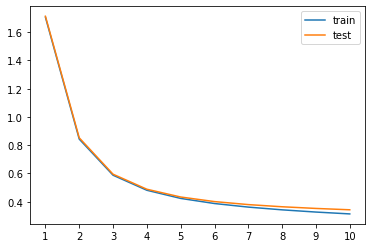

In [39]:
plt.plot(list(range(1, nn.epoch+1)), nn.loss_train, label='train')
plt.plot(list(range(1, nn.epoch+1)), nn.loss_val, label='test') # change
plt.legend()
plt.xticks(list(range(1, nn.epoch+1)));